### Defining Functions:

In [53]:
import numpy as np
from scipy.special import factorial as f

Z = 2
e = (1.602e-19 * np.sqrt(1/(4*np.pi*8.854e-12))) # J
e_sq_raw = e**2
e_sq = (e**2 / 1.6e-19) * 1e10 #14.4 # eV A
hbar_raw = (6.63e-34 / (2*np.pi))
hbar = hbar_raw * 1e10 # A
pi = np.pi
m_e_raw = 9.11e-31 # kg 
m_e = m_e_raw * 1e10 # kg A
r0 = (hbar_raw**2 / (e_sq_raw*m_e_raw)) * 1e10 # 0.5297 # A, hbar**2/m_e*e**2

def expectation_C(vals1,vals2,chi,Z=Z,r0=r0,e=e,return_for_JKM=False): # checked
    j,k,m = vals1
    j2,k2,m2 = vals2
    J,K,M = j+j2,k+k2,m+m2
    lmbd = ((chi*r0)/Z)**(-1)

    if K % 2 == 0 and M != -2:
        C = 8*pi**2 * f(J+K+M+4) * (1/(2*lmbd)**(J+K+M+5)) * (1/(M+2)) * (1/(K+1) - 1/(K+M+3))
    else:
        C = 0
    if return_for_JKM:
        return C
    else:
        return -Z*e_sq*C

def expectation_N(vals1,vals2,chi,Z=Z,r0=r0): # checked
    j,k,m = vals1
    j2,k2,m2 = vals2
    J,K,M = j+j2,k+k2,m+m2
    lmbd = ((chi*r0)/Z)**(-1)
    if K % 2 == 0 and M != -2:
        N = 2*pi**2 * f(J+K+M+5) * 1/(2*lmbd)**(J+K+M+6) * (1/(M+2)) * (1/(K+1) - 1/(K+M+3)- 1/(K+3) + 1/(K+M+5))
    else:
        N = 0
    return N

def expectation_W(vals1,vals2,chi,r0=r0,Z=Z,e=e,show=False): # checked
    temp_vals1 = vals1.copy()
    temp_vals1[-1] -= 1
    return e_sq*expectation_N(temp_vals1,vals2,chi,r0=r0,Z=Z)
    
def expectation_T(vals1,vals2,chi,Z=Z,r0=r0,show=False): # checked
    j,k,m = vals1
    j2,k2,m2 = vals2
    J,K,M = j+j2,k+k2,m+m2
    lmbd = Z/(chi*r0)
    
    N1 = expectation_N([j,k,m],[j2,k2,m2],chi,Z=Z,r0=r0)
    N2 = expectation_N([j-1,k,m],[j2,k2,m2],chi,Z=Z)
    N3 = expectation_N([j-2,k,m],[j2,k2,m2],chi,Z=Z)
    N4 = expectation_N([j,k-2,m],[j2,k2,m2],chi,Z=Z)
    N5 = expectation_N([j,k,m-2],[j2,k2,m2],chi,Z=Z)
    C1 = expectation_C([j,k,m],[j2,k2,m2],chi,Z=Z,r0=r0,return_for_JKM=True)
    C2 = expectation_C([j,k+2,m-2],[j2,k2,m2],chi,Z=Z,r0=r0,return_for_JKM=True)
    C3 = expectation_C([j-1,k,m],[j2,k2,m2],chi,Z=Z,r0=r0,return_for_JKM=True)
    C4 = expectation_C([j-1,k+2,m-2],[j2,k2,m2],chi,Z=Z,r0=r0,return_for_JKM=True)
    C5 = expectation_C([j+1,k,m-2],[j2,k2,m2],chi,Z=Z,r0=r0,return_for_JKM=True)
    C6 = expectation_C([j-1,k,m],[j2,k2,m2],chi,Z=Z,r0=r0,return_for_JKM=True)

    T = (r0*e_sq/2) * ( 2*(lmbd**2*N1 - J*lmbd*N2 + j*j2*N3 + k*k2*N4 + m*m2*N5) + 0.5*(-M*lmbd*(C1-C2)+(m*j2+j*m2)*(C3-C4)+(m*k2+m2*k)*(C5-C6)) )
    return T

def findEigen(matrix): # checked
    eigenvals,eigenvects = np.linalg.eig(matrix)
    presort = zip(eigenvals,eigenvects.T)
    postsort = sorted(presort,key=lambda pair: pair[0],reverse=False)
    eigenvals,eigenvects = zip(*postsort)
    return list(eigenvals),list(eigenvects)

def buildDiagonal(diagElements): # checked
    R = len(diagElements)
    diag = np.zeros((R,R),dtype=np.single)
    for i,val in enumerate(diagElements):
        diag[i][i] = val 
    return diag

def buildEigenVectorMatrix(eigenvectorArray): # checked
    EigenVecMatrix = np.array(eigenvectorArray).T
    return EigenVecMatrix

def invRootDiagonal(diagonalMatrix): # checked
    inverse_root_matrix = np.zeros((len(diagonalMatrix),len(diagonalMatrix)),dtype=np.single)
    for i in range(len(diagonalMatrix)):
        if diagonalMatrix[i][i] != 0:
            inverse_root_matrix[i][i] = 1 / np.sqrt(diagonalMatrix[i][i])
        else:
            inverse_root_matrix[i][i] = 0
    return inverse_root_matrix

def rootDiagonal(diagonalMatrix): # checked
    root_matrix = np.zeros((len(diagonalMatrix),len(diagonalMatrix)),dtype=np.single)
    for i in range(len(diagonalMatrix)):
        root_matrix[i][i] = np.sqrt(diagonalMatrix[i][i])
    return root_matrix

def expectation_H(vals1,vals2,chi,r0=r0,Z=Z,e=e): # checked
    return expectation_T(vals1,vals2,chi,r0=r0,Z=Z,show=True) + expectation_W(vals1,vals2,chi,r0=r0,Z=Z,e=e,show=False) + expectation_C(vals1,vals2,chi,r0=r0,Z=Z,return_for_JKM=False)

### Helium atom simulation:

In [78]:
states = [[0,3,0],[0,0,1],[0,2,0]]
chis = np.arange(0.5,5,0.1)

def find_energy_eigenvalues(states,chi):
    H = np.zeros((len(states),len(states)),dtype=np.single)
    N = np.zeros((len(states),len(states)),dtype=np.single)
    
    for row,(j,k,m) in enumerate(states):
        for col,(j2,k2,m2) in enumerate(states):
            H[row][col] = expectation_H([j,k,m],[j2,k2,m2],chi=chi)
            N[row][col] = expectation_N([j,k,m],[j2,k2,m2],chi=chi)
            
    N_eigenvals,N_eigenvects = findEigen(N)

    beta = buildDiagonal(N_eigenvals)
    Y = buildEigenVectorMatrix(N_eigenvects)
    beta_minus_half = invRootDiagonal(beta)
    
    P = beta_minus_half @ Y.T @ H @ Y @ beta_minus_half
    print(N)

    approx_Es,z = findEigen(P)
    # 'z' represents the eigernvectors of P, ie. z.
    E_approx = sorted(approx_Es)[0]
    
    def returnAs(beta,Y,E,z=z):
        beta_minus_half = invRootDiagonal(beta)
        Y_T_inv = np.linalg.inv(Y.T)
        A = [Y_T_inv @ beta_minus_half @ z[i] for i in range(len(z))] # return the vector A for the best energy approximation
        return A
    
    return E_approx,approx_Es,returnAs(beta,Y,E_approx,z)

Es = [find_energy_eigenvalues(states,chi)[0] for chi in chis]
bestApprox = min(Es)
print('Approximate energy level: {:.2f} eV'.format(bestApprox))

[[3.2419923e-08 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 5.6150998e-06 5.9660965e-07]
 [0.0000000e+00 5.9660965e-07 1.4780031e-07]]
[[2.8905930e-07 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 2.4143901e-05 3.0783747e-06]
 [0.0000000e+00 3.0783747e-06 9.1514056e-07]]
[[1.8380123e-06 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 8.2867031e-05 1.2326580e-05]
 [0.0000000e+00 1.2326580e-05 4.2751931e-06]]
[[9.1253969e-06 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 2.4116669e-04 4.0998704e-05]
 [0.0000000e+00 4.0998704e-05 1.6250817e-05]]
[[3.75043855e-05 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.18781778e-04 1.18343065e-04]
 [0.00000000e+00 1.18343065e-04 5.27716184e-05]]
[[0.00013279 0.         0.        ]
 [0.         0.00143747 0.00030546]
 [0.         0.00030546 0.00015135]]
[[0.00041676 0.         0.        ]
 [0.         0.00308133 0.00072027]
 [0.         0.00072027 0.00039256]]
[[0.00118399 0.         0.        ]
 [0.         0.00618084 0.00157613]
 [0.         0.001576

[[3, 8, 0], [3, 6, 0], [1, 8, 0], [1, 6, 0], [3, 2, 0]]
[[2, 6, 0], [5, 10, 0], [3, 4, 0], [4, 10, 0], [1, 8, 0], [3, 8, 0], [4, 4, 0]]
[[2, 2, 0], [1, 8, 0], [4, 4, 0], [1, 10, 0], [2, 8, 0], [4, 8, 0], [2, 8, 0], [4, 4, 0], [2, 6, 0], [5, 8, 0]]
[[5, 2, 0], [1, 8, 0], [5, 2, 0], [2, 8, 0], [1, 10, 0], [5, 4, 0], [3, 2, 0], [3, 10, 0], [5, 10, 0], [3, 10, 0], [1, 8, 0], [1, 10, 0], [2, 8, 0], [2, 10, 0], [5, 10, 0]]
[[3, 4, 0], [2, 4, 0], [4, 6, 0], [3, 10, 0], [1, 6, 0], [4, 10, 0], [4, 10, 0], [4, 8, 0], [1, 8, 0], [4, 6, 0], [4, 6, 0], [2, 8, 0], [5, 8, 0], [2, 6, 0], [4, 2, 0], [4, 8, 0], [1, 2, 0], [5, 10, 0], [3, 6, 0], [4, 8, 0]]
[[5.3330987e-05]]
[[0.00015925]]
[[0.00040156]]
[[0.00089475]]
[[0.00181391]]
[[0.00341318]]
[[0.00604666]]
[[0.01019171]]
[[0.01647478]]
[[0.02569968]]
[[0.03887829]]
[[0.05726371]]
[[0.08238594]]
[[0.11608995]]
[[0.16057621]]
[[0.21844372]]
[[0.29273546]]
[[0.38698637]]
[[0.5052736]]
[[0.6522694]]
[[0.83329666]]
[[1.0543861]]
[[1.322337]]
[[1.6447798

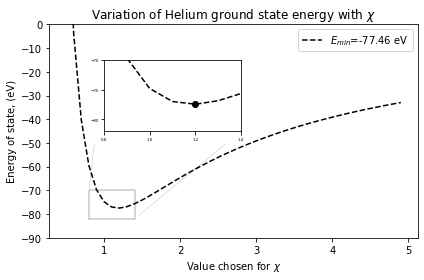

[[5.3330987e-05 1.5454003e-05 1.4037749e-06]
 [1.5454003e-05 5.6150998e-06 5.9660965e-07]
 [1.4037749e-06 5.9660965e-07 1.4780031e-07]]
[[1.5924546e-04 5.5374483e-05 6.0359753e-06]
 [5.5374483e-05 2.4143901e-05 3.0783747e-06]
 [6.0359753e-06 3.0783747e-06 9.1514056e-07]]
[[4.0155757e-04 1.6290606e-04 2.0716758e-05]
 [1.6290606e-04 8.2867031e-05 1.2326580e-05]
 [2.0716758e-05 1.2326580e-05 4.2751931e-06]]
[[8.9474546e-04 4.1484021e-04 6.0291673e-05]
 [4.1484021e-04 2.4116669e-04 4.0998704e-05]
 [6.0291673e-05 4.0998704e-05 1.6250817e-05]]
[[1.81390543e-03 9.46125016e-04 1.54695445e-04]
 [9.46125016e-04 6.18781778e-04 1.18343065e-04]
 [1.54695445e-04 1.18343065e-04 5.27716184e-05]]
[[0.00341318 0.00197811 0.00035937]
 [0.00197811 0.00143747 0.00030546]
 [0.00035937 0.00030546 0.00015135]]
[[0.00604666 0.00385478 0.00077033]
 [0.00385478 0.00308133 0.00072027]
 [0.00077033 0.00072027 0.00039256]]
[[0.01019171 0.00708793 0.00154521]
 [0.00708793 0.00618084 0.00157613]
 [0.00154521 0.001576

[[19864.004       0.          0.     ]
 [    0.        405.06744   413.17245]
 [    0.        413.17245   982.6247 ]]
[[25440.457       0.          0.     ]
 [    0.        477.7119    497.42197]
 [    0.        497.42197  1207.6361 ]]
[[3.2419923e-08 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 5.6150998e-06 5.9660965e-07]
 [0.0000000e+00 5.9660965e-07 1.4780031e-07]]
[[2.8905930e-07 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 2.4143901e-05 3.0783747e-06]
 [0.0000000e+00 3.0783747e-06 9.1514056e-07]]
[[1.8380123e-06 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 8.2867031e-05 1.2326580e-05]
 [0.0000000e+00 1.2326580e-05 4.2751931e-06]]
[[9.1253969e-06 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 2.4116669e-04 4.0998704e-05]
 [0.0000000e+00 4.0998704e-05 1.6250817e-05]]
[[3.75043855e-05 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.18781778e-04 1.18343065e-04]
 [0.00000000e+00 1.18343065e-04 5.27716184e-05]]
[[0.00013279 0.         0.        ]
 [0.         0.00143747 0.00030546]
 [0

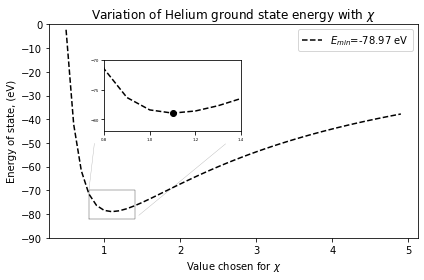

[[1.23960547e-07 5.63518014e-08 4.02512867e-08 2.14086811e-08
  2.17840821e-08]
 [5.63518014e-08 3.12896127e-08 2.14086811e-08 1.40955825e-08
  1.97048031e-08]
 [4.02512867e-08 2.14086811e-08 1.52919153e-08 9.64434577e-09
  1.18228813e-08]
 [2.14086811e-08 1.40955825e-08 9.64434577e-09 7.65010011e-09
  1.31334659e-08]
 [2.17840821e-08 1.97048031e-08 1.18228813e-08 1.31334659e-08
  4.49688535e-08]]
[[2.0434236e-05 6.4508981e-06 4.6077844e-06 1.7019227e-06 1.2026152e-06]
 [6.4508981e-06 2.4874255e-06 1.7019227e-06 7.7816276e-07 7.5543483e-07]
 [4.6077844e-06 1.7019227e-06 1.2156590e-06 5.3242712e-07 4.5326090e-07]
 [1.7019227e-06 7.7816276e-07 5.3242712e-07 2.9328646e-07 3.4965666e-07]
 [1.2026152e-06 7.5543483e-07 4.5326090e-07 3.4965666e-07 8.3140333e-07]]
[[1.5306240e-03 3.5500684e-04 2.5357632e-04 6.8811780e-05 3.5723668e-05]
 [3.5500684e-04 1.0057106e-04 6.8811780e-05 2.3115315e-05 1.6486665e-05]
 [2.5357632e-04 6.8811780e-05 4.9151269e-05 1.5815742e-05 9.8919991e-06]
 [6.8811780e-0

[[2.1921153e+20 1.1277997e+18 8.0557128e+17 4.8490696e+15 5.5840854e+13]
 [1.1277997e+18 7.0871014e+15 4.8490696e+15 3.6132318e+13 5.7164864e+11]
 [8.0557128e+17 4.8490696e+15 3.4636211e+15 2.4722111e+13 3.4298918e+11]
 [4.8490696e+15 3.6132318e+13 2.4722111e+13 2.2193417e+11 4.3120195e+09]
 [5.5840854e+13 5.7164864e+11 3.4298918e+11 4.3120195e+09 1.6709270e+08]]
[[3.9525561e+20 1.9496643e+18 1.3926174e+18 8.0371025e+15 8.8737338e+13]
 [1.9496643e+18 1.1746535e+16 8.0371025e+15 5.7418277e+13 8.7095706e+11]
 [1.3926174e+18 8.0371025e+15 5.7407875e+15 3.9286187e+13 5.2257423e+11]
 [8.0371025e+15 5.7418277e+13 3.9286187e+13 3.3813627e+11 6.2988544e+09]
 [8.8737338e+13 8.7095706e+11 5.2257423e+11 6.2988544e+09 2.3401923e+08]]
[[7.0406638e+20 3.3326197e+18 2.3804427e+18 1.3183046e+16 1.3967315e+14]
 [3.3326197e+18 1.9267528e+16 1.3183046e+16 9.0376740e+13 1.3155083e+12]
 [2.3804427e+18 1.3183046e+16 9.4164613e+15 6.1836720e+13 7.8930503e+11]
 [1.3183046e+16 9.0376740e+13 6.1836720e+13 5.107

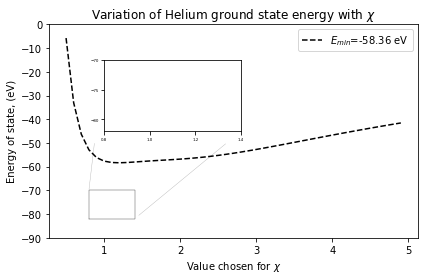

[[1.40955825e-08 2.29892521e-07 1.56616196e-08 1.23960547e-07
  1.40533150e-08 3.40317641e-08 2.17840821e-08]
 [2.29892521e-07 2.44756684e-05 1.73544777e-07 1.05580375e-05
  3.26382803e-07 1.33160927e-06 3.21849541e-07]
 [1.56616196e-08 1.73544777e-07 1.97048031e-08 9.70430563e-08
  1.40955825e-08 3.12896127e-08 2.61026987e-08]
 [1.23960547e-07 1.05580375e-05 9.70430563e-08 4.68836015e-06
  1.69920568e-07 6.48532591e-07 1.73544777e-07]
 [1.40533150e-08 3.26382803e-07 1.40955825e-08 1.69920568e-07
  1.52919153e-08 4.02512867e-08 2.05394599e-08]
 [3.40317641e-08 1.33160927e-06 3.12896127e-08 6.48532591e-07
  4.02512867e-08 1.23960547e-07 4.97387340e-08]
 [2.17840821e-08 3.21849541e-07 2.61026987e-08 1.73544777e-07
  2.05394599e-08 4.97387340e-08 3.63068047e-08]]
[[7.7816276e-07 4.5475867e-05 7.2051466e-07 2.0434236e-05 9.3099516e-07
  3.2465016e-06 1.2026152e-06]
 [4.5475867e-05 1.7348399e-02 2.8607930e-05 6.2362971e-03 7.7475546e-05
  4.5517323e-04 6.3666215e-05]
 [7.2051466e-07 2.86079

[[5.5111205e+10 7.4023225e+17 8.7477330e+09 5.7020188e+16 3.8462161e+11
  4.5638931e+13 8.5171864e+10]
 [7.4023225e+17 6.4902886e+25 7.9828264e+16 3.9995818e+24 7.3564530e+18
  1.4706662e+21 1.0363252e+18]
 [8.7477330e+09 7.9828264e+16 1.5722908e+09 6.3769285e+15 5.5111205e+10
  5.9945024e+12 1.4579554e+10]
 [5.7020188e+16 3.9995818e+24 6.3769285e+15 2.5371978e+23 5.4712819e+17
  1.0232248e+20 7.9828264e+16]
 [3.8462161e+11 7.3564530e+18 5.5111205e+10 5.4712819e+17 2.9296440e+12
  3.7785817e+14 5.6213930e+11]
 [4.5638931e+13 1.4706662e+21 5.9945024e+12 1.0232248e+20 3.7785817e+14
  5.7020188e+16 6.6703057e+13]
 [8.5171864e+10 1.0363252e+18 1.4579554e+10 7.9828264e+16 5.6213930e+11
  6.6703057e+13 1.4195311e+11]]
[[1.02423110e+11 1.67558796e+18 1.58058947e+10 1.25485458e+17
  7.35235015e+11 9.22989814e+13 1.58290264e+11]
 [1.67558796e+18 1.78938767e+26 1.75679641e+17 1.07206366e+25
  1.71278216e+19 3.62256944e+21 2.34582318e+18]
 [1.58058947e+10 1.75679641e+17 2.76198938e+09 1.36440051e

 [  0.        10.747564  17.040216]]
[[221.48239    0.         0.      ]
 [  0.        20.216639  14.177044]
 [  0.        14.177044  23.180069]]
[[316.89758    0.         0.      ]
 [  0.        25.670172  18.546864]
 [  0.        18.546864  31.243845]]
[[448.73346    0.         0.      ]
 [  0.        32.369934  24.075352]
 [  0.        24.075352  41.74993 ]]
[[629.2192     0.         0.      ]
 [  0.        40.552483  31.022924]
 [  0.        31.022924  55.335052]]
[[874.1634    0.        0.     ]
 [  0.       50.49068  39.69865]
 [  0.       39.69865  72.77673]]
[[1203.8575      0.          0.      ]
 [   0.         62.498013   50.467594]
 [   0.         50.467594   95.01918 ]]
[[1644.1719      0.          0.      ]
 [   0.         76.93329    63.75903 ]
 [   0.         63.75903   123.203026]]
[[2227.8801     0.         0.     ]
 [   0.        94.20574   80.07559]
 [   0.        80.07559  158.69937]]
[[2996.2512     0.         0.     ]
 [   0.       114.78055  100.00344]
 [   0.   

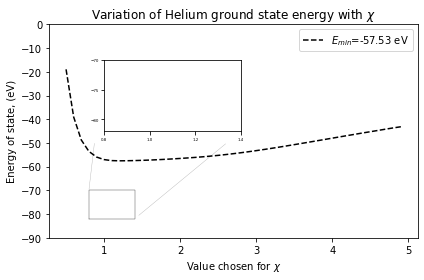

[[4.88119198e-08 9.39477562e-09 2.43907223e-08 1.01339888e-08
  1.18228813e-08 2.17840821e-08 1.18228813e-08 2.43907223e-08
  1.31334659e-08 3.17428004e-08]
 [9.39477562e-09 1.52919153e-08 2.05394599e-08 2.97509501e-08
  2.43084042e-08 6.93164708e-08 2.43084042e-08 2.05394599e-08
  1.40533150e-08 1.23960547e-07]
 [2.43907223e-08 2.05394599e-08 3.63068047e-08 3.40317641e-08
  3.12896127e-08 8.23603230e-08 3.12896127e-08 3.63068047e-08
  2.17840821e-08 1.41832160e-07]
 [1.01339888e-08 2.97509501e-08 3.40317641e-08 6.96334936e-08
  5.12339113e-08 1.69920568e-07 5.12339113e-08 3.40317641e-08
  2.43084042e-08 3.26382803e-07]
 [1.18228813e-08 2.43084042e-08 3.12896127e-08 5.12339113e-08
  4.02512867e-08 1.23960547e-07 4.02512867e-08 3.12896127e-08
  2.14086811e-08 2.29892521e-07]
 [2.17840821e-08 6.93164708e-08 8.23603230e-08 1.69920568e-07
  1.23960547e-07 4.41576702e-07 1.23960547e-07 8.23603230e-08
  5.63518014e-08 8.77426487e-07]
 [1.18228813e-08 2.43084042e-08 3.12896127e-08 5.12339113e

<ipython-input-53-d89241645b68>:89: RuntimeWarning: invalid value encountered in sqrt
  inverse_root_matrix[i][i] = 1 / np.sqrt(diagonalMatrix[i][i])


LinAlgError: Array must not contain infs or NaNs

In [79]:
import matplotlib.pyplot as plt
import os
import plottools
import random

file_dir = os.path.abspath('')

states_array = [[[0,0,0]],[[0,0,0],[0,0,1],[0,2,0]]]

numbers = [5,7,10,15,20]
#print('\n'.join(states_array))

for i in range(len(numbers)):
    cache = []
    for k in range(numbers[i]):
        cache.append([random.randint(1,len(numbers)),2*random.randint(1,len(numbers)),0])#random.randint(1,len(numbers))])
    states_array.append(cache)
    print(states_array[-1])

minimum = []

for num in range(len(states_array)):

    Es = [find_energy_eigenvalues(states_array[num],chi)[0] for chi in chis]
    bestApprox = min(Es)
    minimum.append(bestApprox)

    E2 = [find_energy_eigenvalues(states,chi)[1][-2] for chi in chis]
    E3 = [find_energy_eigenvalues(states,chi)[1][-1] for chi in chis]

    fig,ax = plt.subplots()
    ax.plot(chis,Es,'k--',label=r'$E_{{min}}$={0:.2f} eV'.format(bestApprox))
    #ax.plot(chis,E2,'r--',label=r'$E_{{001}}$={0:.2f} eV'.format(min(E2)))
    #ax.plot(chis,E3,'b--',label=r'$E_{{020}}$={0:.2f} eV'.format(min(E3)))
    ax.set_title(r'Variation of Helium ground state energy with $\chi$')
    ax.set_xlabel(r'Value chosen for $\chi$')
    ax.set_ylabel(r'Energy of state, (eV)')
    ax.legend(loc='upper right')
    ax.set_ylim(-90,0)

    zoomed_ax = plottools.zoom_axes(fig,ax,zoom_x=[0.8,1.4],zoom_y=[-82,-70],axes_x=[1,2.8],axes_y=[-45,-15],box=True)
    zoomed_ax.plot(chis,Es,'k--')
    zoomed_ax.plot(chis[Es.index(min(Es))],min(Es),'ko')

    fig.savefig('ground state plot '+str(len(states_array[num]))+'.png')
    plt.show()
    
print(minimum)

#print('Approximate E2 energy level: {:.2f} eV'.format(min(E2)))
#print('Approximate E3 energy level: {:.2f} eV'.format(min(E3)))